In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from os import listdir
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, precision_score, roc_auc_score, recall_score, average_precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

In [2]:
# Function used to score the models, returns a dictionary of the scores
def score_model(model, X_test, y_test, map = None):
    model_preds = model.predict(X_test)
    scores = {}
    if map:
        model_preds = [map[i] for i in model_preds]
    evaluation_funcs = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score, 'f1':f1_score, 'MCC':matthews_corrcoef}
    for name, score in evaluation_funcs.items():
        scores[name] = score(y_pred = model_preds, y_true = y_test)
    scores['ROC-AUC'] = roc_auc_score(y_score = model_preds, y_true = y_test)
    scores['AUPR'] = average_precision_score(y_score = model_preds, y_true = y_test)
    return scores

In [3]:
transaction_df = pd.read_csv('original_data.csv')
transaction_df.replace("'",'', regex=True, inplace=True) 
#Drop unused columns
transaction_df.drop(columns = ['step', 'age', 'gender', 'zipcodeOri', 'zipMerchant'], inplace=True)
#Split data to train, test
train, test = train_test_split(transaction_df, random_state=42)

In [4]:
# Create merchant fraud rate, 1 - 5 value of fraud rates in merchants in train set
mechant_fraud_rate = train.groupby('merchant').mean('fraud')['fraud']
train['merchant fraud rate'] = train['merchant'].apply(lambda x: mechant_fraud_rate.get(x))
test['merchant fraud rate'] = test['merchant'].apply(lambda x: mechant_fraud_rate.get(x))

In [5]:
# Create previous fraud per customer. 1 if there was fraud in the test set, 0 if not
customer_previous_fraud = train.groupby('customer').sum('fraud')['fraud']
train['previous fraud'] = train['customer'].apply(lambda x: customer_previous_fraud.get(x))
test['previous fraud'] = test['customer'].apply(lambda x: customer_previous_fraud.get(x))

In [6]:
# Create category fraud rate, 1 - 5 value of fraud rate in train set
category_fraud_rate = train.groupby('category').mean('fraud')['fraud']
train['category fraud rate'] = train['category'].apply(lambda x: category_fraud_rate.get(x))
test['category fraud rate'] = test['category'].apply(lambda x: category_fraud_rate.get(x))

In [7]:
train.drop(columns=['customer', 'merchant', 'category'], inplace=True)
test.drop(columns=['customer', 'merchant', 'category'], inplace=True)
train.head()

,amount,fraud,merchant fraud rate,previous fraud,category fraud rate
458422,40.54,0,0.0,0,0.0
102312,38.63,0,0.0,0,0.0
253447,61.62,0,0.0,6,0.0
585032,41.24,0,0.0,0,0.0
136214,4.74,0,0.0,0,0.0


In [8]:
# Make feature and target vectors
y_train = train['fraud']
X_train = train.drop(columns = ['fraud'])
y_test = test['fraud']
X_test = test.drop(columns = ['fraud'])

In [9]:
#Fit transformer to data
MMscaler = MinMaxScaler()
X_train_transformed = MMscaler.fit_transform(X_train)
X_test_transformed = MMscaler.transform(X_test)

In [10]:
#Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_transformed, y_train)
dec_tree_scores = score_model(decision_tree, X_test_transformed, y_test)
dec_tree_scores

{'accuracy': 0.994901150940731,
 'precision': 0.7934911242603551,
 'recall': 0.7662857142857142,
 'f1': 0.7796511627906977,
 'MCC': 0.7771937008122901,
 'ROC-AUC': 0.881955063172358,
 'AUPR': 0.6107921388768104}

In [11]:
# Random Forest
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest.fit(X_train_transformed, y_train)
random_forest_scores = score_model(random_forest, X_test_transformed, y_test)
random_forest_scores

{'accuracy': 0.9955200086101936,
 'precision': 0.8292831105710814,
 'recall': 0.78,
 'f1': 0.8038869257950529,
 'MCC': 0.802008103408122,
 'ROC-AUC': 0.8890436386655867,
 'AUPR': 0.649430611057869}

In [12]:
# KNN
KNN = KNeighborsClassifier(n_jobs=-1)
KNN.fit(X_train_transformed, y_train)
KNN_scores = score_model(KNN, X_test_transformed, y_test)
KNN_scores

{'accuracy': 0.9964684752557833,
 'precision': 0.8820960698689956,
 'recall': 0.808,
 'f1': 0.8434237995824635,
 'MCC': 0.8424699546757269,
 'ROC-AUC': 0.9033567534085263,
 'AUPR': 0.7149938002904471}

In [13]:
#Multilayer perceptron
MLP = MLPClassifier(hidden_layer_sizes=(15, 15, 15), random_state=42)
MLP.fit(X_train_transformed, y_train)
MLP_scores = score_model(MLP, X_test_transformed, y_test)
MLP_scores

{'accuracy': 0.9962734005556265,
 'precision': 0.8903394255874674,
 'recall': 0.7794285714285715,
 'f1': 0.8312004875076173,
 'MCC': 0.8312015226313816,
 'ROC-AUC': 0.889142510966309,
 'AUPR': 0.6965524980983987}

In [14]:
#Support Vector machine
SVM = SVC(random_state=42)
SVM.fit(X_train_transformed, y_train)
SVM_scores = score_model(SVM, X_test_transformed, y_test)
SVM_scores

{'accuracy': 0.996650096528343,
 'precision': 0.9086161879895561,
 'recall': 0.7954285714285714,
 'f1': 0.8482632541133454,
 'MCC': 0.8484929313011659,
 'ROC-AUC': 0.8972378067576385,
 'AUPR': 0.7251474399292727}

In [15]:
#Isolation forest
y_train_transformed = y_train.map({0:1, 1:-1})

ISO = IsolationForest(contamination=sum(y_train)/len(y_train), random_state=42, n_jobs=-1)
ISO.fit(X_train_transformed, y_train_transformed)
ISO_scores = score_model(ISO, X_test_transformed, y_test, map={1:0, -1:1})
ISO_scores

{'accuracy': 0.9953854743342235,
 'precision': 0.7975391498881432,
 'recall': 0.8148571428571428,
 'f1': 0.8061051441492368,
 'MCC': 0.803817856401139,
 'ROC-AUC': 0.9061965329835266,
 'AUPR': 0.6520599282652836}

In [16]:
#Local Outlier Factor
LOF = LocalOutlierFactor(novelty=True, contamination=sum(y_train)/len(y_train), n_jobs=-1)
LOF.fit(X_train_transformed)
LOF_scores = score_model(LOF, X_test_transformed, y_test, map={1:0, -1:1})
LOF_scores

{'accuracy': 0.978561963124155,
 'precision': 0.11183144246353323,
 'recall': 0.11828571428571429,
 'f1': 0.11496806442654818,
 'MCC': 0.10416826375281,
 'ROC-AUC': 0.5535476328233713,
 'AUPR': 0.023607381442498653}

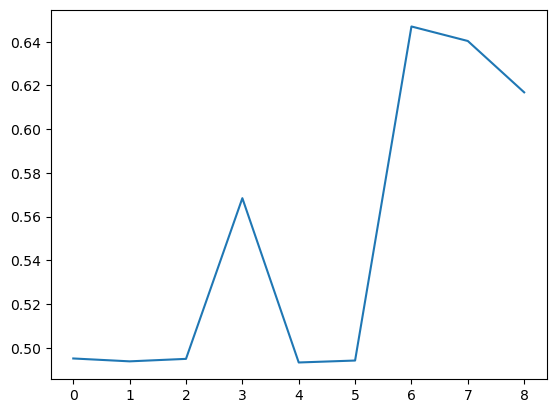

: 

In [17]:
#LOF fun
from IPython.display import clear_output

roc_aucs = []
for n in range(1, 20):
    clear_output(wait=True)
    LOF = LocalOutlierFactor(novelty=True, n_neighbors=2**n, contamination=sum(y_train)/len(y_train), n_jobs=-1)
    LOF.fit(X_train_transformed)
    LOF_scores = score_model(LOF, X_test_transformed, y_test, map={1:0, -1:1})
    roc_aucs.append(LOF_scores['ROC-AUC'])
    plt.plot(roc_aucs)
    plt.show()

In [ ]:
scores = {
            'Decision Tree': dec_tree_scores,
            'Random Forest': random_forest_scores,
            'K-NN': KNN_scores,
            'MLP': MLP_scores,
            'SVM': SVM_scores,
            'LOF': LOF_scores,
            'IF': ISO_scores
            }
scores_df = pd.DataFrame(scores)

In [ ]:
(100 * scores_df).round(2).T.to_csv('engineered_features.csv')